In [ ]:
!pip install datasets
from IPython.display import clear_output
clear_output()

# **Q1.** Autograd for MLPs from scratch (20 pts)

Automatic differentiation is the backbone of modern deep learning toolkits like Torch, JAX, TensorFlow, and MLX. To build an understanding of how these tools work, we will define functions and their gradients/Jacobians and compose them together to as the building blocks of a neural network

The gradient of a real-valued function $f:\mathbb{R}^n\to\mathbb{R}$ is a vector where
$$\nabla f(\boldsymbol{x})_{i}=\frac{\partial f(\boldsymbol{x})}{\partial x_i}$$

The Jacobian is a generalization of the gradient for a vector-valued function $f:\mathbb{R}^m\to\mathbb{R}^n$. It is a $m\times n$ matrix where
$$J_f(\boldsymbol{x})_{i,j}=\frac{\partial f(\boldsymbol{x})_i}{\partial x_j}$$

Neural nets are generally built from composed functions. To calculate the Jacobian of composed functions, we can use matrix multiplication to apply the chain rule.

$$
J_{f\circ g}(\boldsymbol{x})
= J_f(g(\boldsymbol{x}))J_g(\boldsymbol{x})
$$

([Proof](https://math.stackexchange.com/questions/3260609/how-to-show-jacobian-of-a-composite-function-is-the-product-of-jacobians).)

We will define a series of functions which take 2D inputs and return 2D outputs.
```
arg1: (M, N)
arg2: (O, P)
...
returns: (Q, R)
```
We will also define Jacobian functions, which return the function output as well as the Jacobian vector of each of the inputs.
```
arg1: (M, N)
arg2: (O, P)
...
returns: (Q, R), (Q, R, M, N), (Q, R, O, P), ...
```
Note that the first two dimensions of the Jacobians match the output shape (Q, R), and the last two match the dimensions of the arguments so that they can be composed together

```python
output1, jac1 = func1_and_jac(x) # Shape: (M, N, O, P)
output2, jac2 = func2_and_jac(output1) # Shape: (O, P, Q, R)
jac = np.einsum("mnop,opqr->mnqr", jac1, jac2) # Shape (M, N, Q, R)
```

In [ ]:
import jax
import jax.numpy as np
from numpy import testing
import math

def test(func, func_and_jac, *params):
  testing.assert_allclose(func(*params), func_and_jac(*params)[0])
  for i in range(len(params)):
    print(f"Testing Jacobian of parameter {i}")
    testing.assert_allclose(jax.jacfwd(func, argnums=i)(*params), func_and_jac(*params)[i + 1])
  print("All passed!")

In [ ]:
# Reference implementation of a func_and_jac function.
def add_and_jac(x, y):
  output = x + y
  x_jac = np.eye(math.prod(x.shape)).reshape(*x.shape, *x.shape)
  x_jac = np.broadcast_to(x_jac, (*output.shape, *x.shape))
  y_jac = np.eye(math.prod(y.shape)).reshape(*y.shape, *y.shape)
  y_jac = np.broadcast_to(y_jac, (*output.shape, *y.shape))
  return output, x_jac, y_jac

x, y = np.arange(24).reshape(2, 3, 4).astype(float)
test(np.add, add_and_jac, x, y)

Testing Jacobian of parameter 0
Testing Jacobian of parameter 1
All passed!


## Q1.1 (5 pts)
Now its your turn: define the Jacobian of the matmul function. You can use `jax.jacfwd` to help check your work, but you should only use `numpy` functions in your solution.

In [ ]:
def matmul_and_jac(x, y):
  # TODO: define the Jacobian for the matmul function.
  ### BEGIN IMPLEMENTATION ###
    output = np.matmul(x, y)

    m, n = x.shape
    n2, p = y.shape
    x_jac = np.zeros((m, p, m, n))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                x_jac = x_jac.at[i, j, i, k].set(y[k, j])

    y_jac = np.zeros((m, p, n, p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                y_jac = y_jac.at[i, j, k, j].set(x[i, k])

    return output, x_jac, y_jac

  #pass

x = np.arange(12).reshape(3, 4).astype(float)
y = np.arange(20).reshape(4, 5).astype(float)
test(np.matmul, matmul_and_jac, x, y)

Testing Jacobian of parameter 0
Testing Jacobian of parameter 1
All passed!


## Q1.2 (5 pts)

Now we will define a function that combine `matmul` and `add` to define the *affine* function (sometimes misleadingly called the "linear" function in neural network libraries)

In [ ]:
def affine(x, w, b):
  return np.dot(x, w) + b

def affine_and_jac(x, w, b):
  # TODO: use add_and_jac and matmul_and_jac
  # to define the Jacobian of the affine function
  ### BEGIN IMPLEMENTATION ###

  output, xjx, wjw = matmul_and_jac(x, w)

  ret, dxw, bias = add_and_jac(output, b)

  return ret, xjx, wjw, bias

  #pass

x = np.arange(12).reshape(3, 4).astype(float)
w = np.arange(20).reshape(4, 5).astype(float)
b = np.arange(5).reshape(1, 5).astype(float)
test(affine, affine_and_jac, x, w, b)

Testing Jacobian of parameter 0
Testing Jacobian of parameter 1
Testing Jacobian of parameter 2
All passed!


## Q1.3 (5 pts)
Now lets define the Jacobian of some nonlinear functions (we'll implemnt `relu`, you implement `logsoftmax`.)

In [ ]:
def relu(x):
  return np.maximum(x, 0)

def relu_and_jac(x):
  # Some libraries define $d relu(0) / dx$ to be 0.5.
  x_jac = (np.diagflat(x > 0) + np.diagflat(x == 0) / 2).reshape(*x.shape, *x.shape)
  return np.maximum(x, 0), x_jac

def logsoftmax(x):
  stabilized_x = x - np.max(x, axis=1, keepdims=True)
  return stabilized_x - np.log(np.sum(np.exp(stabilized_x), axis=1, keepdims=True))

def logsoftmax_and_jac(x):
  # TODO: define the Jacobian of the log_softmax function
  ### BEGIN IMPLEMENTATION ###

    stabilized_x = x - np.max(x, axis=1, keepdims=True)
    softmax = np.exp(stabilized_x) / np.sum(np.exp(stabilized_x), axis=1, keepdims=True)
    logs = stabilized_x - np.log(np.sum(np.exp(stabilized_x), axis=1, keepdims=True))

    m, n = x.shape
    jacobian = np.ones((m, n, m, n))

    for i in range(m):
        for j in range(n):
            for k in range(m):
                for l in range(n):
                    if i == k:
                        if j == l:
                            jacobian = jacobian.at[i, j, k, l].set(1 - softmax[i, j])
                        else:
                            jacobian = jacobian.at[i, j, k, l].set(-softmax[i, l])
                    else:
                        jacobian = jacobian.at[i, j, k, l].set(0)

    return logs, jacobian

x = np.arange(12).reshape(3, 4).astype(float)
test(logsoftmax, logsoftmax_and_jac, x)

Testing Jacobian of parameter 0
All passed!


Now that you have all the building blocks, we can compose them together to create an MLP and its Jacobian!

In [ ]:
# Here are some utilities to deal with nested parameters and composing the Jacobians we defined.
def tree_map(func, *trees: np.ndarray | tuple[np.ndarray], **kwargs):
  if not isinstance(trees[0], tuple):
    return func(*trees, **kwargs)
  else:
    return tuple(tree_map(func, *subtrees, **kwargs) for subtrees in zip(*trees))

def sequential(func_and_jac_seq):
  def func_and_jac(x, params_seq):
    params_jac = ()
    x, x_jac, _ = add_and_jac(x, np.zeros_like(x))
    for func_and_jac, params in zip(func_and_jac_seq, params_seq):
      x, x_layer_jac, *param_layer_jacs = func_and_jac(x, *params)
      params_jac = tree_map(lambda param: np.einsum("...kl,klmn->...mn", x_layer_jac, param), params_jac)
      x_jac = np.einsum("...kl,klmn->...mn", x_layer_jac, x_jac)
      params_jac += (tuple(param_layer_jacs),)
    return x, x_jac, params_jac
  return func_and_jac

# Here is a 2-layer MLP
def mlp(x, params):
  affine1_params, _, affine2_params, _ = params
  return logsoftmax(affine(relu(affine(x, *affine1_params)), *affine2_params))

# ...and its Jacobian!
mlp_and_jac = sequential(
    [affine_and_jac, relu_and_jac, affine_and_jac, logsoftmax_and_jac]
)

import numpy

mlp_params = (
    (
      numpy.random.randn(10,100), # first matmul
      numpy.random.randn(1, 100) # first bias
    ),
    (), # relu has no params
    (
      numpy.random.randn(100,10), # final matmul
      numpy.random.randn(1, 10) # final bias
    ),
    (), # logsoftmax has no params
)

x = numpy.random.randn(3,10)
y = np.eye(10)[numpy.random.randint(0, 10, size=3)]
print("Testing MLP Jacobian")
tree_map(
  numpy.testing.assert_allclose,
  jax.jacfwd(mlp, argnums=1)(x, mlp_params),
  mlp_and_jac(x, mlp_params)[2],
  atol=1e-5
)
print("Passed!")

Testing MLP Jacobian
Passed!


## Q1.4 (5 pts)
Given the MLP Jacobian, if we define a loss function and its gradient, we can compose them together to get the parameter gradients of the MLP.

In [ ]:
def cross_entropy_loss(params, x, y):
  logprobs = mlp(x, params)
  return -np.mean(np.sum(logprobs * y, axis=1))

def cross_entropy_loss_and_grad(logprobs, y):
    return -np.mean(np.sum(logprobs * y, axis=1)), -y / logprobs.shape[0]

x = numpy.random.randn(3,10)
y = np.eye(10)[numpy.random.randint(0, 10, size=3)]
logprobs, x_jac, params_jac = mlp_and_jac(x, mlp_params)
loss, output_grad = cross_entropy_loss_and_grad(logprobs, y)

 # TODO: Write the function to compute the parameter gradients
    # using the output_grad and each parameter jacobian.
    # BEGIN IMPLEMENTATION

param_grads = tree_map(lambda jac: np.einsum('bi,bijk->jk', output_grad, jac), params_jac)

print("Testing MLP grad")
jax_grads = jax.grad(cross_entropy_loss)(mlp_params, x, y)
tree_map(numpy.testing.assert_allclose, param_grads, jax_grads, atol=1e-5)
print("All tests passed!")

Testing MLP grad
All tests passed!


Now that you have a taste for how autodiff works, take a look at this example, where we use JAX's autograd to do gradient descent, training an MLP to mimic a the sine function.

Epoch 0, Loss: 22.767864227294922
Epoch 1000, Loss: 0.06815874576568604
Epoch 2000, Loss: 0.02795281633734703
Epoch 3000, Loss: 0.012034187093377113
Epoch 4000, Loss: 0.0061746444553136826
Epoch 5000, Loss: 0.0037407446652650833
Epoch 6000, Loss: 0.0024744884576648474
Epoch 7000, Loss: 0.0017195675754919648
Epoch 8000, Loss: 0.0013325471663847566
Epoch 9000, Loss: 0.00105439149774611


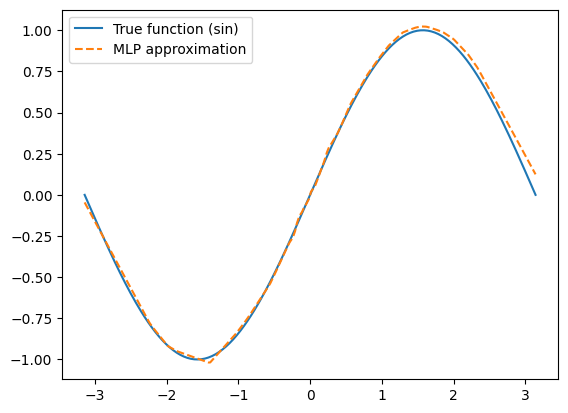

In [ ]:
# Nothing to do in this cell, just a reference implementation.

import jax.numpy as jnp
from jax import random, grad, jit
import matplotlib.pyplot as plt

# 1. Define the MLP Model
def init_mlp_params(layer_sizes, key):
    """Initialize the parameters for an MLP."""
    params = []
    keys = random.split(key, len(layer_sizes) - 1)
    for in_size, out_size, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weight_key, bias_key = random.split(key)
        W = random.normal(weight_key, (in_size, out_size)) * jnp.sqrt(2.0 / in_size)
        b = jnp.zeros(out_size)
        params.append((W, b))
    return params

def mlp(params, x):
    """Forward pass for an MLP."""
    activations = x
    for W, b in params[:-1]:
        activations = jax.nn.relu(jnp.dot(activations, W) + b)
    final_W, final_b = params[-1]
    return jnp.dot(activations, final_W) + final_b

# 2. Define the loss function
def loss_fn(params, x, y):
    predictions = mlp(params, x)
    return jnp.mean((predictions - y) ** 2)

# 3. Generate data (sine function between -π and π)
key = random.PRNGKey(0)
x_train = jnp.linspace(-jnp.pi, jnp.pi, 256).reshape(-1, 1)
y_train = jnp.sin(x_train)

# 4. Initialize the model parameters
layer_sizes = [1, 64, 64, 1]  # MLP with two hidden layers
params = init_mlp_params(layer_sizes, key)

# 5. Gradient Descent update rule
learning_rate = 0.01  # Set a suitable learning rate

@jit
def update(params, x, y):
    """Performs one update step using plain gradient descent."""
    grads = grad(loss_fn)(params, x, y)  # Compute gradients
    new_params = [(W - learning_rate * dW, b - learning_rate * db)
                  for (W, b), (dW, db) in zip(params, grads)]
    return new_params

# 6. Train the model
num_epochs = 10000
for epoch in range(num_epochs):
    params = update(params, x_train, y_train)
    if epoch % 1000 == 0:
        loss = loss_fn(params, x_train, y_train)
        print(f'Epoch {epoch}, Loss: {loss}')

# 7. Plot the results
x_test = jnp.linspace(-jnp.pi, jnp.pi, 256).reshape(-1, 1)
y_pred = mlp(params, x_test)

plt.plot(x_train, y_train, label='True function (sin)')
plt.plot(x_test, y_pred, label='MLP approximation', linestyle='dashed')
plt.legend()
plt.show()

# Q2. Co-occurrence Embeddings (20 points)
Consider the technique of embedding words to vectors using counts of context co-occurrences, as taught in class.

Here we will implement this technique to find embeddings for each unique word in the Shakespeare corpus. Later in the assignment, we will compare them to word embeddings learnt using Word2vec.



## Q2.1 Co-occurrence + PPMI (15 points)

(Full credit if close enough to the asserted value)

Fill in the code to complete the implementation of calculating co-occurrences and also weighing them by PPMI (Positive Pointwise Mutual Infomation) as taught in class. All assert statements should pass. Use a span length of `5` words on each side (total window length 11) as already set default in the starter code provided.

Note: Use log base e in your PPMI formula as mentioned in class slides.

In [ ]:
# Download data - do not change
import requests
import numpy as np
from tqdm.notebook import tqdm
import time

url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
response.raise_for_status() # Raise an exception for invalid HTTP status codes
text_data = response.text
len(text_data), text_data[:100]


(1115394,
 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou')

In [ ]:

# preprocessing - do not change
text_data = response.text
text_data = text_data.replace(',',' , ').replace('.',' . ').replace('?',' ? ').replace('!',' ! ')
text_data = text_data.replace('  ', ' ')
text_data = text_data.replace('\n\n','\n').replace('\n',' </s> <s> ')
text_data = '<s> ' + text_data + ' </s>'
len(text_data), text_data[:100]

(1451204,
 '<s> First Citizen: </s> <s> Before we proceed any further , hear me speak .  </s> <s> All: </s> <s> ')

In [ ]:
data = text_data.split(' ')
vocab = list(set(data))
revmap = {v:k for k,v in enumerate(vocab)} # dictionary to map words to indices


In [ ]:
counts = np.zeros(shape=(len(vocab), len(vocab)))
assert counts.shape == (18118, 18118)

span_length = 5
start_time = time.time()

# IMPLEMENT HERE

for i,w in tqdm(enumerate(data), total=len(data)):
  # Hint: calculate co-occurrences in each window

  ind = revmap[w]
  begin = i - span_length
  fin = i + span_length + 1

  if begin < 0:
      begin = 0
  if fin > len(data):
      fin = len(data)

  for j in range(begin, fin):
      if i != j:
          context_w = revmap[data[j]]
          counts[ind, context_w] += 1

# Hint: calculate PPMI values using co-occurrences
cocurr = counts / np.sum(counts)
pi = np.sum(counts, axis=1) / np.sum(counts)
pj = np.sum(counts, axis=0) / np.sum(counts)

cocurr = np.clip(cocurr, 1e-10, None)
pi = np.clip(pi, 1e-10, None)
pj = np.clip(pj, 1e-10, None)

ppmi = np.maximum(0, np.log(cocurr / (pi[:, np.newaxis] * pj[np.newaxis, :]))) #make shapes compatible

# Hint: Find L2 norms to convinently calculate cosine similiarity scores
ppmi_norms = np.linalg.norm(ppmi, axis=1)

### END OF IMPLEMENTATION ####
print("--- %s seconds ---" % (time.time() - start_time))
# Note down this Training Time

assert ppmi.shape == (len(vocab), len(vocab))
assert counts[revmap['First'],revmap['Citizen:']] == 44.
np.testing.assert_allclose(ppmi[revmap['First'],revmap['Citizen:']], 4.024266, rtol=1e-3)

  0%|          | 0/316243 [00:00<?, ?it/s]

--- 18.222723245620728 seconds ---


## Q2.2 Nearest Neighbours (5 points)
Implement the function `get_nearest_neighbours` which given a target word (e.g., `eye`) or a vector (e.g., `[0.123, 1.993, ...]` as well as a 2D array `vectors` and the corresponding list of words `vocab`, returns `top_k` words that are most similar to the target vector in the embedding space, as measured by cosine similarity. Note that the closest word to the vector of `eye` must be `eye`.

In [ ]:
def get_nearest_neighbours(word_or_vector, vectors=ppmi, top_k=5, vocab=vocab,
                           norms=ppmi_norms):
  # IMPLEMENT HERE
    if type(word_or_vector) == str:
      entry = revmap[word_or_vector]
      vectarget = vectors[entry]
    else:
      vectarget = word_or_vector

    target_norm = np.linalg.norm(vectarget)
    cos = np.dot(vectors, vectarget) / (norms * target_norm)

    sorted_word = np.argsort(-cos)

    nearest_neighbours = []
    for i in range(top_k):
        wordval = sorted_word[i]
        nearest_neighbours.append(vocab[wordval])

    return nearest_neighbours
  # Hint: L2 norms can be used for ease of calculating cosine similarity.
  # Hint: avoid iterating over vocabulary and use np.dot matrix multiplication.
  # Hint: sort by cosine similarity scores.

In [ ]:
get_nearest_neighbours('he')
print(get_nearest_neighbours('he'))
assert 'he' in get_nearest_neighbours('he')

['he', 'sours', 'money;', 'scotched', 'grapes:']


Here we will evaluate the embeddings on Analogy Task. You do not need to implement anything in this subsection.
Do not be concerned if your output results in a low score. Hit@100 is a metric which checks whether the ground truth answer was among the top 100 predictions made by a model.

**Do note down the time taken to run inference over the benchmark, and the final Hit@100 scores.**


In [ ]:
# Download and preprocessing data - do not change
import requests
import numpy as np
from tqdm.notebook import tqdm

url = "http://download.tensorflow.org/data/questions-words.txt"
response = requests.get(url)
response.raise_for_status() # Raise an exception for invalid HTTP status codes
analogy = response.text.split('\n')

# filtering out analogies that do not exist in our vocabulary
task = []
for line in tqdm(analogy, total=len(analogy)):
  row = line.split(' ')
  if len(row) != 4 or line.startswith(':'):
    continue
  if sum(_ in vocab for _ in row) == 4:
    task.append(row)
len(task), task[-1]

  0%|          | 0/19559 [00:00<?, ?it/s]

(2396, ['write', 'writes', 'work', 'works'])

In [ ]:
# Inference over Analogy Benchmark - do not change
start_time = time.time()
acc = 0.
for a,b,c,d in tqdm(task[:50]): # Note down this Inference Time
  d_ = get_nearest_neighbours(
        word_or_vector=ppmi[revmap[a]]+ppmi[revmap[b]]-ppmi[revmap[c]],
        top_k=100
      )
  if d in d_:
    acc += 1
print('inference time:', time.time() - start_time)
acc/len(task)

  0%|          | 0/50 [00:00<?, ?it/s]

inference time: 16.991018772125244


0.0008347245409015025

# **Q3.** Word2vec Gradient Derivation (10 points)

Remember the negative sampling loss function for Word2vec from the [lecture](https://drive.google.com/file/d/1xN5FiqtutlFrhID64qDGA3DqaZMIZfMh/view). Given the target word embedding $w$, context word embedding $c_\text{pos}$ from positive examples, and $K$ noise word embeddings $c_\text{neg$_i$}$ from negative examples,

$L = - [\log \sigma(w.c_\text{pos})+\Sigma_{i=1..K} \log \sigma(-w.c_\text{neg$_i$})]$

where $\sigma$ is the sigmoid function.

## ***Q3.1*** Derive the following gradients. (4 points)
**Hint:** First show that $\frac{\partial \sigma(x)}{\partial x} = \sigma(x) (1 - \sigma(x))$, and then use this throughout your derivations. Also, if you're not comfortable with LaTeX, feel free to write your answer on a sheet of paper and upload an image here.

$\frac{∂ L}{∂ w}$

$\frac{∂ L}{∂ c_\text{pos}}$

$\frac{∂ L}{∂ c_\text{neg$_i$}}$

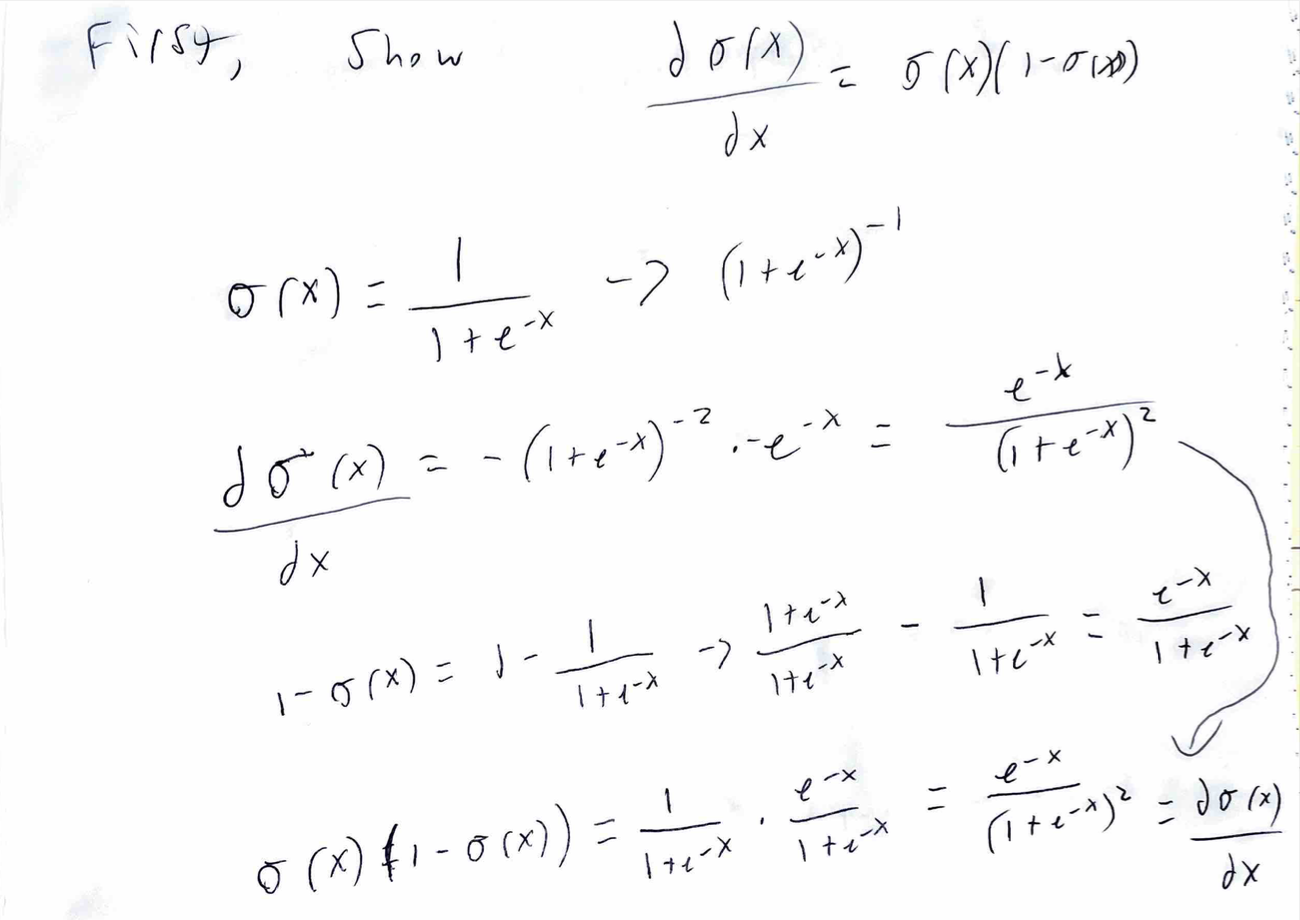

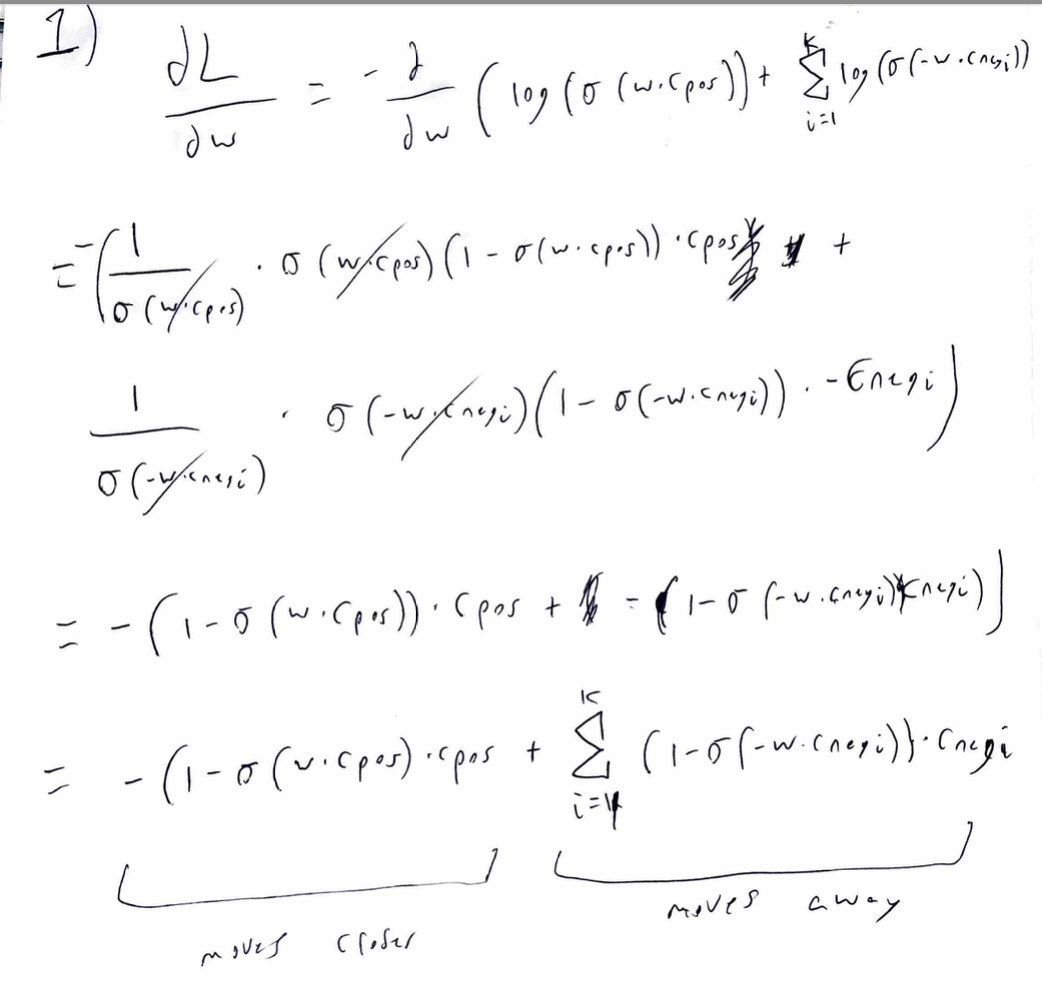




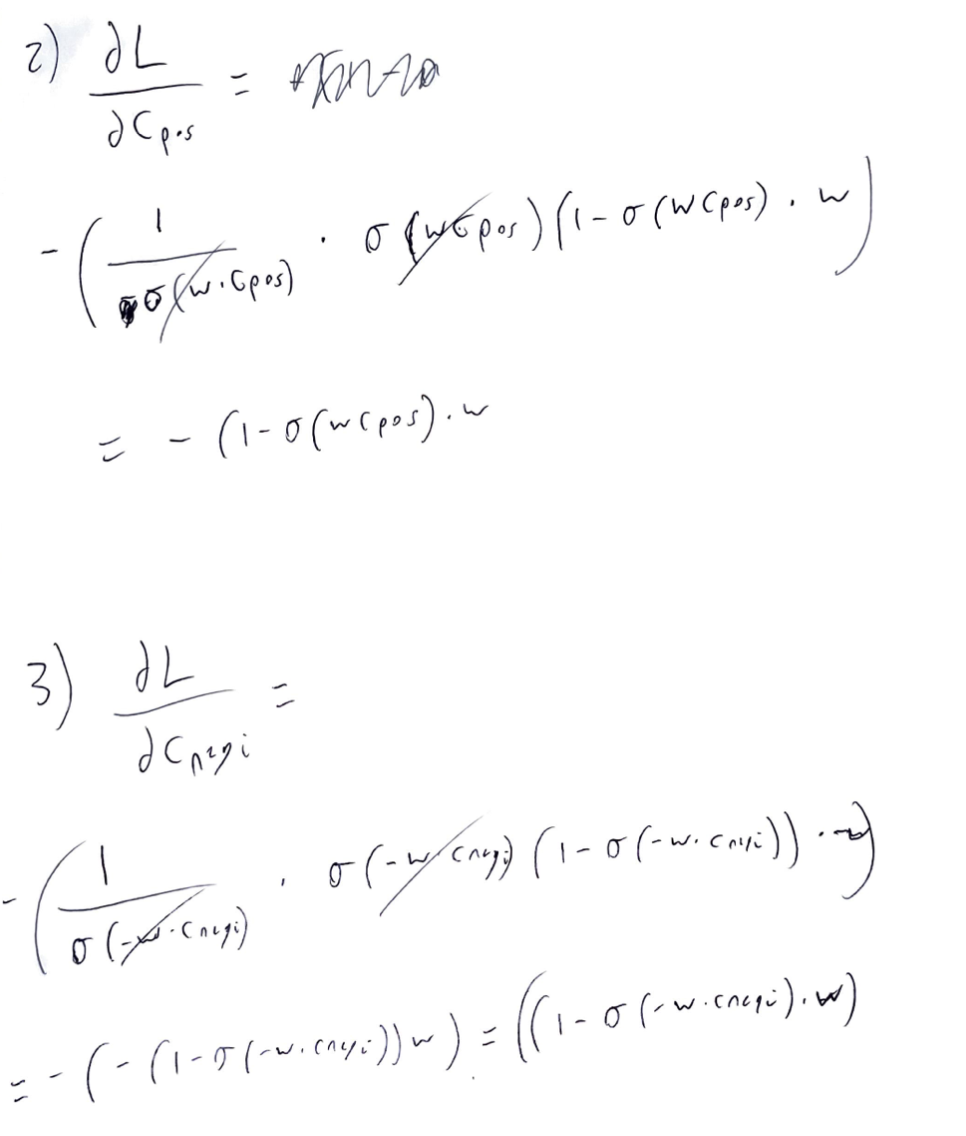

## ***Q3.2*** In your own words, describe intuitively how embeddings change when updated using SGD under the gradients above (no additional equations besides the gradients above required, description in words is enough). (3 points)

1. Since the w gradient takes into account both the positive and negative word contexts, it has to simultaneously move the target embedding close to Cpos, the positive context, and farther from Cneg, the negative context
2. As stated above, the gradient with respect to Cpos moves the target closer to Cpos, creating a stronger correlation between the two
3. The graident with respect to Cneg moves the target away from Cneg, to create seperation and distinction between them

## ***Q3.3*** Why is negative sampling required? What happens if we solely rely on positive examples? (3 points)

Without negative sampling, you're only looking at positive samples, meaning that model would only learn which word pairs go together. Since it never distinguished correct and incorrect context words it can't accurately access which word associations fit and which don't. Without seeing what shouldn't appear in the context of a word will mean if it sees a word that clearly shouldn't fit, it won't be able to accurately rule it out.

# Q4. Learn Word2Vec Embeddings (20 points)

Here we will convert the above equations into code and learn word2vec embeddings for each word. We will then compare these embeddings to those learnt using PPMI in Q1.

## Q4.1 Learning Word2vec (15 points)

Implement the Word2Vec as taught in class. Use a span length of `5` words on each side (total window length 11), `50` dimensions per embeddings, `0.01` learning rate, `15` negative samples per target word, and `500_000` number of iterations or trainig updates, as already set default in the starter code provided.

While calculating the loss explicitly is not needed to find gradient updates, we require you to calculate it so we can log it every 10K steps (code already provided - do not change). This will help track the loss as it goes down over training steps.

Hint: Do not try to find real negatives for a given context, instead randomly sample 15 words from the vocabulary to use as negative samples, and given the size of the vocabulary, it is very unlikely to include a word among the 11 context words.

**Updated Hint**: Also optionally do not try to find samples without replacement. You can use `np.random.randint` to instead sample with replacement, which is much more efficient hence brings down training time.



In [ ]:
import scipy.special
import numpy as np

D = 50 # embedding_dimensions
w_vectors = np.random.rand(len(vocab), D) # target
c_vectors = np.random.rand(len(vocab), D) # context and noise

In [ ]:
start_time = time.time()
LR = 1e-2 # learning_rate
K = 15 # num_negatives
span_length = 5 # number of words before and after target in context
num_iter = 500_000 # number of iterations or update steps

losses = []
for iter in tqdm(range(num_iter)): # # Note down this Training Time
  # IMPLEMENT HERE
  # Hint: Pick a random target word from data, then iterate over each positive word in its context (using span_length)
  # Hint: Fetch target, context, and negatives from w_vectors and c_vectors.
  # Hint: Calculate gradient updates as derived in Q2.
  # Hint: You may use scipy.special.expit function to implement sigmoid.
  # Hint: Apply gradient updates to parts of w_vectors and c_vectors properly

    target = np.random.randint(0, len(data))
    target_word = data[target]

    index = revmap[target_word]

    start = max(0, target - span_length)
    end = min(len(data), target + span_length + 1)

    contexts = []
    for j in range(start, end):
        if j != target:
            contexts.append(data[j]) #grab contexts words around it

    contexts_word = []
    for word in contexts:
        contexts_word.append(revmap[word])

    neg_words = np.random.randint(0, len(vocab), size=K) #get neg samples

    targetv = w_vectors[index] #get vecs
    context_v = c_vectors[contexts_word]
    negative_v = c_vectors[neg_words]

    positive_scores = np.dot(context_v, targetv)  #get pos score and run sigmoid
    sigmoid = scipy.special.expit(positive_scores)

    negative_scores = np.dot(negative_v, targetv)   #get neg and run sig
    neg_sigmoid = scipy.special.expit(-negative_scores)

    sigmoid = np.clip(sigmoid, 1e-7, 1 - 1e-7)
    neg_sigmoid = np.clip(neg_sigmoid, 1e-7, 1 - 1e-7) #trying to bring down loss

    #pos_loss = -np.log(1-sigmoid + 1e-10).sum()
    #neg_loss = -np.sum(np.log(neg_sigmoid + 1e-10))
    pos_loss = -np.log(sigmoid + 1e-10).sum()      #get two loses
    neg_loss = -np.sum(np.log(neg_sigmoid + 1e-10))
    losses.append(pos_loss + neg_loss)

    pos_gradi = (1-sigmoid).reshape(-1, 1) #converts to column vector
    neg_gradi = (neg_sigmoid).reshape(-1, 1)

    update = np.dot(context_v.T, pos_gradi).squeeze() + \
                           np.dot(negative_v.T, neg_gradi).squeeze() #squeeze since shapes didn't match

    grad_norm = np.linalg.norm(update)
    if grad_norm > 10:
        update = (update / grad_norm) * 10 #had exploding gradient problem

    w_vectors[index] -= LR * update  #update target vec, move toward context words away from negs

    c_vectors[contexts_word] -= LR * pos_gradi * targetv
    c_vectors[neg_words] -= LR * neg_gradi * targetv

    if iter%10_000 == 0:
      print(sum(losses)/len(losses)) # This should go down as training proceeds
      losses = [] # resetting log every 10K steps

print('training time:', time.time()-start_time)

  0%|          | 0/500000 [00:00<?, ?it/s]

177.28979689159485
188.70390818858166
188.5821267450703
188.10568214225358
188.25375841411298
188.14742302512454
188.0993660242017
187.73188799577477
187.86733214556358
187.1929477633322
187.40330265260022
186.91654992571267
186.66648622813224
186.77067621578146
186.56019968639671
186.01560879824245
186.17691937599471
185.77732452963653
184.6368229171955
183.56161811653854
186.77975420886497
200.20572327485186
214.62896464205008
223.96464730623015
229.75376448721892
232.49671638757573
234.50701630364935
235.5758666102172
236.2784736122327
236.1820728029876
236.43890039528702
236.58123986793066
236.76116972267135
236.7926746961178
236.73759706981392
236.73093060697215
236.61417234845106
236.63279778827922
236.68391093644448
236.4087869147228
236.69026821343783
236.5172896970228
236.55680904300394
236.81505185463052
236.97752244693902
236.57367349006972
236.87481625360726
229.2894760367673
219.65990457282044
219.56320199651606
training time: 90.4886782169342


In [ ]:
w_vectors_norms = np.linalg.norm(w_vectors, axis=1)
c_vectors_norms = np.linalg.norm(c_vectors, axis=1)

In [ ]:
get_nearest_neighbours('First', vectors=w_vectors, top_k=5, vocab=vocab,
                       norms=w_vectors_norms)

['First', 'ready;', 'Bless', 'wakes', 'carrion-flies']

In [ ]:
get_nearest_neighbours('First', vectors=c_vectors, top_k=5, vocab=vocab,
                       norms=c_vectors_norms)

['First', 'No', 'too', 'shall', 'one']

In [ ]:
# evaluation - do not change
start_time = time.time()
hit_at_k = 0.
for a,b,c,d in tqdm(task): # Note down this Inference Time
  d_ = get_nearest_neighbours(
        word_or_vector=w_vectors[revmap[a]]+w_vectors[revmap[b]]-w_vectors[revmap[c]],
        top_k=100,
        vectors=w_vectors,
        norms=w_vectors_norms,
      )
  # Note that we could have used c_vectors as well instead of w_vectors
  if d in d_:
    hit_at_k += 1
hit_at_k/=len(task)
print('inference time:', time.time() - start_time)
print(hit_at_k)

  0%|          | 0/2396 [00:00<?, ?it/s]

inference time: 8.854191780090332
0.005008347245409015


## Q4.2 Comparison of embeddings (3 points)

Now that we have trained two variants of embeddings, we can compare their results in terms of:
- Analogy Task Hit@100 scores
- Training and Inference Speed (time taken)
- Memory Requirement

Fill the following evaluations (based on runtime of the main loops within each embedding method, and total memory required for the embedding arrays):


In [ ]:
import sys # Hint: use sys.getsizeof() and convert to MBs

ppmi_memory = sys.getsizeof(ppmi)
print(ppmi_memory)

sgns_memory = sys.getsizeof(w_vectors) + sys.getsizeof(c_vectors)
print(sgns_memory)

# IMPLEMENT HERE

2626095520
14494656


\# COMPLETE THIS TABLE.

Round each value up to two decimal points and use seconds for speed, MBs for memory, and % for Analogy Hit@100 scores.

Method|Training Speed|Inference Speed|Memory|Analogy
---|---|---|---|---
PPMI| 10.14 | 6 | 2626095520
SGNS| 57.3 | 6.6 | 14494656

## Q4.3 Difference in Results (2 points)

Could you hypothesize the cause of the differences in training speed, inference speed, memory, and analogy results between the two methods?

**\# INSERT ANSWER HERE** \\


# Q5. Context Aware Embeddings using Self-Attention (25 + 5 points)

In this last question, you will build upon all the implementation done from Q1-4 to build your own context-aware embeddings using Self-Attention mechanism.

## Recap Self-Attention

Recall that Self-Attention is a type of a scaled dot-product attention. It allows the model to weigh different positions of a sequence differently when constructing a representation of that sequence. This is crucial in NLP tasks because it enables the model to focus on relevant parts of a sentence, regardless of their position in the sequence.

Given an input sequence with $n$ tokens, each token is first converted into an embedding vector. Let's denote these embeddings as $\mathbf{X} \in \mathbb{R}^{n \times d_{\text{model}}}$, where $d_{\text{model}}$ is the dimension of the embeddings.

For each token, we compute three vectors: Query ($\mathbf{Q}$), Key ($\mathbf{K}$), and Value ($\mathbf{V}$). These vectors are obtained by multiplying the input embeddings by three learnable weight matrices:

$$
\mathbf{Q} = \mathbf{X}\mathbf{W}_Q, \quad \mathbf{K} = \mathbf{X}\mathbf{W}_K, \quad \mathbf{V} = \mathbf{X}\mathbf{W}_V
$$

where:

*  $\mathbf{W}_Q \in \mathbb{R}^{d_{\text{model}} \times d_k}$,
*  $\mathbf{W}_K \in \mathbb{R}^{d_{\text{model}} \times d_k}$
*  $\mathbf{W}_V \in \mathbb{R}^{d_{\text{model}} \times d_v}$

$d_k$ and $d_v$ are the dimensions of the Query/Key and Value vectors, respectively.

The attention mechanism calculates the attention scores between the Query and Key vectors to determine how much focus should be placed on different tokens in the sequence.

The attention scores are computed using the dot product of the Query and Key vectors, scaled by the square root of the dimension of the Key vectors $d_k$:

$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d_k}}\right)\mathbf{V}
$$

Here:

* $\mathbf{Q}\mathbf{K}^\top$ gives the similarity scores between the Query and Key vectors.
* $\frac{1}{\sqrt{d_k}}$ is a scaling factor to prevent the dot products from growing too large, which could lead to very small gradients.
* The softmax function normalizes the scores so that they sum to 1.
* The resulting matrix is then multiplied by the Value matrix $\mathbf{V}$ to produce the output.



In this question, we will use a PyTorch-style autograd (again implemented in NumPY) instead of the JAX-style autograd from Q1. Let's first define an abstract class that will be the base of all neural network components and a few basic components. Here, backpropagation relies on forward and backward passes to calculate the gradients required for updating parameters. So each component needs to have a `forward` and `backward` method.

In [ ]:
# do not change
import numpy as np

from abc import ABC, abstractmethod

class NNComp(ABC):
    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def backward(self, incoming_grad):
        pass


class Linear(NNComp):
    def __init__(self, in_dim, out_dim):
        k = 1 / in_dim
        self.in_dim = in_dim
        self.out_dim = out_dim

        # forward stuff, we need to initialize the weight and the bias
        self.weight = np.random.uniform(-np.sqrt(k), np.sqrt(k), size=(in_dim, out_dim))
        self.bias = np.random.uniform(-np.sqrt(k), np.sqrt(k), size=out_dim)

        # backward stuff
        self.backward_context = None
        self.dweight = np.empty_like(self.weight, dtype=float)
        self.dbias = np.empty_like(self.bias, dtype=float)

    def forward(self, x):
        assert np.shape(x)[-1] == self.in_dim
        self.backward_context = x
        return x @ self.weight + self.bias

    def backward(self, incoming_grad):
        self.dweight = self.backward_context.T @ incoming_grad
        self.dbias = incoming_grad.sum(axis=0)
        return incoming_grad @ self.weight.T

    def update_parameters(self, lr):
        self.weight -= lr * self.dweight
        self.bias -= lr * self.dbias


class LogSoftmax(NNComp):
    def __init__(self):
        self.backward_context = None

    def forward(self, x):
        self.backward_context = x - np.max(x, axis=-1, keepdims=True)
        return self.backward_context - np.log(np.exp(self.backward_context).sum(axis=-1, keepdims=True))

    def backward(self, incoming_grad):
        softmax = np.exp(self.backward_context) / np.exp(self.backward_context).sum(axis=-1, keepdims=True)
        return incoming_grad - softmax * incoming_grad.sum(axis=-1, keepdims=True)

## ***Q5.1*** Implement the Self-Attention Module. (10 points)

Based on the description of Linear and LogSoftmax classes shown above, implement the Self-Attention module below.

__Hint__: Make use of broadcasting in numpy for operations to implement attention.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
class SelfAttention(NNComp):
  def __init__(self, embed_dim):
    # do not change
    self.embed_dim = embed_dim # Specify the embedding dimension

    # Initializer Q, K, V vectors
    self.query_layer = Linear(embed_dim, embed_dim)
    self.key_layer = Linear(embed_dim, embed_dim)
    self.value_layer = Linear(embed_dim, embed_dim)
    self.softmax = LogSoftmax()

  def forward(self, x):
    # Start with setting up the Q, K, V vectors
    # Compute the attention scores using Q, K and normalize them using softmax
    # Combine the attention weights with V
    # Don't forget to store the backward context
    # IMPLEMENT HERE
    Q = self.query_layer.forward(x)
    K = self.key_layer.forward(x)
    V = self.value_layer.forward(x)

    dqk = self.embed_dim
    scores = np.dot(Q, K.T) / np.sqrt(dqk)

    attention_weights = self.softmax.forward(scores)

    output = np.dot(attention_weights, V)

    self.Q, self.K, self.V = Q, K, V
    self.attention_weights = attention_weights
    return output

  def backward(self, incoming_grad):
    # Implement backward for Self-Attention, feel free to use the backward() functions defined for modules above
    # Utilize the gradient formulation provided above
    # IMPLEMENT HERE
    attentions = np.dot(incoming_grad, self.V.T)

    d_scores = self.softmax.backward(attentions)

    dQ = np.dot(d_scores, self.K)
    dK = np.dot(d_scores.T, self.Q)
    dV = np.dot(self.attention_weights.T, incoming_grad)
    dxq = self.query_layer.backward(dQ)
    dxk = self.key_layer.backward(dK)
    dxv = self.value_layer.backward(dV)

    return dxq + dxk + dxv

  def update_parameters(self, lr):
    # Implement update here
    # IMPLEMENT HERE
    self.query_layer.update_parameters(lr)
    self.key_layer.update_parameters(lr)
    self.value_layer.update_parameters(lr)


## ***Q5.2*** Training Self-Attention Module (10 points)

Now, you will use the word embeddings developed in Q4 (word2vec) and apply Self-Attention on them to obtain **contextual embeddings**.

Contextual embeddings, like those from BERT or GPT, capture the meaning of a word based on the context in which it appears, producing different embeddings for the same word in different contexts. In contrast, Word2Vec generates static embeddings, where each word has a single fixed vector representation regardless of its context.

For this, we will explore a new dataset from the [SuperGLUE Benchmark](https://super.gluebenchmark.com/) called 'Words in Context' (WiC [link text](https://aclanthology.org/N19-1128/)). This task evaluates settings where the "context" of the word is important to infer its meaning -- for example, the meaning of the word "bank" changes when used in context of money or a river.

This dataset comprises of a pair of sentences, and a binary label. The label is 1 if a target word is used in the same context, and 0 otherwise. See examples below.

In [ ]:
# do not change
from datasets import load_dataset

# Load the SuperGLUE WiC dataset
dataset = load_dataset('super_glue', 'wic', trust_remote_code=True)

# Extract the training and testing data
train_data = dataset['train']
test_data = dataset['validation']

# Prepare sentences and labels
sentences_1_train = train_data['sentence1']
sentences_2_train = train_data['sentence2']
labels_train = train_data['label']

sentences_1_test = test_data['sentence1']
sentences_2_test = test_data['sentence2']
labels_test = test_data['label']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Example of an instance where the meaning of the word "place" is not the same
sentences_1_train[0], sentences_2_train[0], labels_train[0]

('Do you want to come over to my place later?',
 'A political system with no place for the less prominent groups.',
 0)

In [ ]:
# Example of an instance where the meaning of the word "summer" is the same
sentences_1_train[4], sentences_2_train[4], labels_train[4]

('We like to summer in the Mediterranean.', 'We summered in Kashmir.', 1)

Given this dataset, you first need to train a Self-Attention Model over the word2vec embeddings, to better learn the context and position of words on this dataset.

For training self-attention, we will make use of a Binary Cross Entropy Loss. First, we perform a forward pass through the self-attention model for both sentences:

$$
\text{output}_1 = \text{AttentionModel}(\text{emb}_1) \quad \text{and} \quad \text{output}_2 = \text{AttentionModel}(\text{emb}_2)
$$

These outputs are the contextual embeddings for the first and second sentences, respectively.

Next, we compute the similarity score between the two outputs using cosine similarity:

$$
\text{similarity} = \frac{\text{output}_1 \cdot \text{output}_2}{\|\text{output}_1\| \|\text{output}_2\|}
$$

We then apply the sigmoid function to this similarity score to obtain a predicted probability:

$$
\text{predicted} = \frac{1}{1 + e^{-\text{similarity}}}
$$

Given a target label $\text{target} \in \{0, 1\}$, we compute the Binary Cross-Entropy Loss:

$$
\text{loss} = - \left( \text{target} \cdot \log(\text{predicted} + 10^{-10}) + (1 - \text{target}) \cdot \log(1 - \text{predicted} + 10^{-10}) \right)
$$

Note that we add $10^{-10}$ for stability in log, during training.

The gradient of the loss with respect to the predicted output is:

$$
\text{grad_loss} = \text{predicted} - \text{target}
$$

Finally, we backpropagate the gradients through the attention model for both embeddings.


In [ ]:
# do not change, helper functions to implement padding for w2v embeddings

def normalize_embeddings(embeddings):
  mean = np.mean(embeddings, axis=0)
  std = np.std(embeddings, axis=0)
  return (embeddings - mean) / (std + 1e-8)

def extract_w2v_embeddings(sentences, max_tokens=10):
  embeddings = []
  for sentence in sentences:
    w2v_embeddings_sentence = []
    words = sentence.split()

    for word in words:
      if word in revmap:
        w2v_embeddings_sentence.append(w_vectors[revmap[word]])

    if len(w2v_embeddings_sentence) < max_tokens:
      pad_tokens = max_tokens - len(w2v_embeddings_sentence)
      w2v_embeddings_sentence.extend([np.zeros(D) for i in range(pad_tokens)])
    else:
      w2v_embeddings_sentence = w2v_embeddings_sentence[:max_tokens]

    embeddings.append(np.array(w2v_embeddings_sentence))

  return embeddings

input_embeddings_1 = extract_w2v_embeddings(sentences_1_train)
input_embeddings_2 = extract_w2v_embeddings(sentences_2_train)

In [ ]:
# Example learning rate and number of epochs
lr = 1e-5
epochs = 10

attention_model = SelfAttention(D)

for epoch in range(epochs):
  total_loss = 0
  for i, (emb1, emb2) in enumerate(zip(input_embeddings_1, input_embeddings_2)):
    # IMPLEMENT HERE
    # Forward pass through self-attention model for both sentences

    # Compute similarity score between the two outputs (e.g., cosine similarity)

    # Define target (either 0 or 1)

    # Compute Binary Cross-Entropy Loss

    # Compute gradient of the loss w.r.t. predicted output

    # Backpropagate the gradients through the attention model for both embeddings

    # Update parameters

    output1 = attention_model.forward(emb1)
    output2 = attention_model.forward(emb2)

    dot = np.dot(output1.flatten(), output2.flatten())
    norm1 = np.linalg.norm(output1) # got norms
    norm2 = np.linalg.norm(output2)
    similarity = dot / (norm1 * norm2) #get cos similarity

    predicted = scipy.special.expit(similarity) #sig

    predicted = np.clip(predicted, 1e-5, 1 - 1e-5) #keep

    target = labels_train[i]
    grad_loss = predicted - target
    loss = -((target * np.log((predicted + 1e-10))) + ((1 - target)) * (np.log(1 - predicted + 1e-10)))
    total_loss += loss

    grad1 = (grad_loss) * output1 #backprop gradients
    grad2 = grad_loss * output2

    attention_model.backward(grad1)
    attention_model.backward(grad2)

    attention_model.update_parameters(lr)

  print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(input_embeddings_1)}")

Epoch 1/10, Loss: 0.7067546762615797
Epoch 2/10, Loss: 0.7099261180621718
Epoch 3/10, Loss: 0.7125537417504769
Epoch 4/10, Loss: 0.7142316446113587
Epoch 5/10, Loss: 0.7154023334239374
Epoch 6/10, Loss: 0.7163097343662446
Epoch 7/10, Loss: 0.7170816581382256
Epoch 8/10, Loss: 0.71779321221553
Epoch 9/10, Loss: 0.7185043333708444
Epoch 10/10, Loss: 0.7193011495184872


## ***Q5.3*** Word2vec vs. Contextual Embeddings (5 points)

We will now compare word2vec embeddings and the contextual embeddings we just made on the WiC task from above. Please make a note of the final accuracies.

Nothing to code here, just note the final accuracies.

In [ ]:
# do not change

# get_sentence_embeddings is a general purpose function that will create sentence embeddings given any type of embeddings
def get_sentence_embeddings(sentences, attention_model=None):
  feature_matrix = np.zeros((len(sentences), D))

  for i, sentence in enumerate(sentences):
    words = sentence.split()

    # We only look for words that occur in our vocabulary (specially since we are using a different dataset to build the vocabulary)
    word_indices = [revmap[word] for word in words if word in revmap]

    # Sentence embeddings are created by aggregating the word embeddings obtained
    if word_indices:
      word_embeddings = w_vectors[word_indices, :]
      if attention_model:
        word_embeddings = attention_model.forward(word_embeddings)
      feature_matrix[i] = np.mean(word_embeddings, axis=0)
    else:
      feature_matrix[i] = np.zeros(D)

  return feature_matrix

In [ ]:
# do not change

# Extract features for both sets of sentences in training and testing
features_1_train_word2vec = get_sentence_embeddings(sentences_1_train)
features_2_train_word2vec = get_sentence_embeddings(sentences_2_train)
features_1_test_word2vec = get_sentence_embeddings(sentences_1_test)
features_2_test_word2vec = get_sentence_embeddings(sentences_2_test)

# Same for contextual embeddings
features_1_train_contextual = get_sentence_embeddings(sentences_1_train, attention_model=attention_model)
features_2_train_contextual = get_sentence_embeddings(sentences_2_train, attention_model=attention_model)
features_1_test_contextual = get_sentence_embeddings(sentences_1_test, attention_model=attention_model)
features_2_test_contextual = get_sentence_embeddings(sentences_2_test, attention_model=attention_model)

In [ ]:
# do not change

import numpy as np

# Combine the features from both sentences for the classifier input
X_train_word2vec = np.concatenate([features_1_train_word2vec, features_2_train_word2vec], axis=1)
X_test_word2vec = np.concatenate([features_1_test_word2vec, features_2_test_word2vec], axis=1)

X_train_contextual = np.concatenate([features_1_train_contextual, features_2_train_contextual], axis=1)
X_test_contextual = np.concatenate([features_1_test_contextual, features_2_test_contextual], axis=1)

In [ ]:
# do not change

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train classifier on word2vec embeddings
clf_word2vec = LogisticRegression(max_iter=1000)
clf_word2vec.fit(X_train_word2vec, labels_train)
pred_word2vec = clf_word2vec.predict(X_test_word2vec)

# Train classifier on contextual embeddings
clf_contextual = LogisticRegression(max_iter=1000)
clf_contextual.fit(X_train_contextual, labels_train)
pred_contextual = clf_contextual.predict(X_test_contextual)

# Evaluate and compare accuracies
accuracy_word2vec = accuracy_score(labels_test, pred_word2vec)
accuracy_contextual = accuracy_score(labels_test, pred_contextual)

print(f"Word2Vec Embeddings Accuracy: {accuracy_word2vec}")
print(f"Contextual Embeddings Accuracy: {accuracy_contextual}")

Word2Vec Embeddings Accuracy: 0.5282131661442007
Contextual Embeddings Accuracy: 0.5109717868338558


## ***Q5.4*** (Bonus) Word2vec vs. Contextual Embeddings (5 points)

What do you observe above from accuracy values, for both contextual and word2vec embeddings? Which one performs better and why?

**[INSERT YOUR ANSWER HERE]**